In [ ]:
# 查看当前挂载的数据集目录, 该目录下的变更重启环境后会自动还原
# View dataset directory. 
# This directory will be recovered automatically after resetting environment. 
!ls /home/aistudio/data

In [ ]:
# 查看工作区文件, 该目录下的变更将会持久保存. 请及时清理不必要的文件, 避免加载过慢.
# View personal work directory. 
# All changes under this directory will be kept even after reset. 
# Please clean unnecessary files in time to speed up environment loading. 
!ls /home/aistudio/work

In [ ]:
# 如果需要进行持久化安装, 需要使用持久化路径, 如下方代码示例:
# If a persistence installation is required, 
# you need to use the persistence path as the following: 
!mkdir /home/aistudio/external-libraries
!pip install beautifulsoup4 -t /home/aistudio/external-libraries

In [ ]:
# 同时添加如下代码, 这样每次环境(kernel)启动的时候只要运行下方代码即可: 
# Also add the following code, 
# so that every time the environment (kernel) starts, 
# just run the following code: 
import sys 
sys.path.append('/home/aistudio/external-libraries')

In [1]:
from util import *
echo("aaaaa")

aaaaa


# 分块加噪

In [2]:
import math
import numpy as np

# 马赛克/像素化图片
def mosaicing(image_org,b = 4,laplace_scal = 0):

    image = image_org.copy()
    # 原始图片为M行，N列
    M, N, _ = image.shape
    # 图片被划分为num块,向上取整
    M_block = math.ceil(M / b)
    N_block = math.ceil(N / b)
    num_blocks = M_block * N_block
    # print(num_blocks)

    # 产生num_blocks个拉普拉斯噪声
    if laplace_scal != 0:
        laplace_noise = np.random.laplace(0, laplace_scal, num_blocks)
    
    maxValue = 0
    minValue = 0
    #重构图片
    for c in range(3):
        cnt = 0
        for i in range(0, M, b):
            for j in range(0, N, b):
                # avg = np.mean(image[i:i+b,j:j+b])
                avg = np.sum(image[i:i+b,j:j+b,c]) / (b*b)
                # print(avg)

                maxValue = max(avg,maxValue)
                minValue = min(avg,minValue)

                # 添加拉普拉斯噪声,提前产生噪声是为了和原论文保持一致
                if laplace_scal != 0:
                    avg += laplace_noise[cnt]
                    cnt += 1
                    
                image[i:i+b,j:j+b,c] = int(avg)
                # print(re_image[i:i+b,j:j+b])
        # image =(image - minValue ) / (maxValue - minValue)
    return image



# 异或操作

In [2]:
import math
import numpy as np

# x = x XOR xorstring
def getXORImg(image_org,xorstring,flag =0):
    image = image_org.copy()
  
    #异或串长度
    lenth = len(xorstring)
    
    if flag == 1:
        print("before xor:")
        for i in range(32):
            for j in range(32):
                print(image[i][j][0],end=" ")
            print()

    index = 0
    for k in range(3):
        for i in range(32):
            for j in range(32):
                xorV = image[i][j][k] ^ xorstring[index]
                if flag == 1 and j == 0:
                    print(xorstring)
                    print("{} and {} xor = {}".format(image[i][j][0],xorstring[index],xorV))
                index = index+1
                if index == lenth:
                    index = 0
                image[i][j][k] = xorV

    if flag == 1: 
        print("after xor:")
        for i in range(32):
            for j in range(32):
                print(image[i][j][0],end=" ")
            print()

    return image

In [33]:

import tarfile
import numpy as np
import six
from PIL import Image
from six.moves import cPickle as pickle

import paddle
from paddle.io import Dataset

CUDA = True
if CUDA:
    paddle.set_device('gpu')
place = paddle.CUDAPlace(0) if CUDA else paddle.CPUPlace()

class MyCifar10(Dataset):

    def __init__(self,
                 data = None,
                 transform=None):
      
        self.data = data
        self.transform = transform

        self.dtype = paddle.get_default_dtype()

    def __getitem__(self, idx):
        image, xor_image = self.data[idx]
        
        if self.transform is not None:
            image = self.transform[0](image)
            xor_image = self.transform[1](xor_image)

        return image.astype(self.dtype), xor_image.astype(self.dtype)

    def __len__(self):
        return len(self.data)

MODE_FLAG_MAP = {
    'train10': 'data_batch',
    'test10': 'test_batch',
    'train100': 'train',
    'test100': 'test'
}

class XORCifar10(Dataset):

    def __init__(self,
                 data_file=None,
                 mode='train',
                 group = 5,
                 xor_num = 4,
                 xor_len = 28,
                 block = 4,
                 laplace_scal = None,
                 paper = "xor",
                 transform = None):
        assert mode.lower() in ['train', 'test', 'train', 'test'], \
            "mode should be 'train10', 'test10', 'train100' or 'test100', but got {}".format(mode)
        self.mode = mode.lower()

        self.paper = paper
        #自定义属性
        self.group = group
        self.xor_num = xor_num
        self.xor_len = xor_len

        #自定义属性
        self.block = block
        self.laplace_scal = laplace_scal
  
        self.transform = transform

        self._init_flag()

        self.data_file = data_file

        self._getXORstring()

        # read dataset into memory
        self._load_data()
        
        self._getLoader()

    def _init_flag(self):
        self.flag = MODE_FLAG_MAP[self.mode + '10']

    def _load_data(self):
        self.data = []
        with tarfile.open(self.data_file, mode='r') as f:
            names = (each_item.name for each_item in f
                     if self.flag in each_item.name)

            names = sorted(list(names))

            for name in names:
                batch = pickle.load(f.extractfile(name), encoding='bytes')

                data = batch[six.b('data')]
                labels = batch.get(
                    six.b('labels'), batch.get(six.b('fine_labels'), None))
                assert labels is not None
                # 得到一个文件里的所有数据，train有5个文件，test有一个文件
                for sample, label in six.moves.zip(data, labels):
                    self.data.append((sample, label))
        
        np.random.seed(1313)
        np.random.shuffle(self.data)

        self._groupXORData()
        print(len(self.data))
    
    def _getXORstring(self):
        self.xorstring = []
        seeds = [33,133,233,1333,2333,333,433,533,633,733,833,933]
        # seeds = [15,115,215,1115,2115,415,515,615,715,815,915,315]
        count = 0
        for k in range(self.group):
            xorArray = []
            myseed = seeds[count]
            count = count+1
            for ttt in range(self.xor_num):
                np.random.seed(myseed)
                myseed = myseed + 2
                xorArray.append(np.random.randint(0,255,size = self.xor_len))
            #     print(xorArray[ttt])
            # print("one's xor string")
            self.xorstring.append(xorArray)

    def _groupXORData(self):
        lenth = len(self.data)
        block = lenth // self.group
        
        self.userData = []
        uu = 0
        for k in range(0,lenth-1, block):
            if uu >= self.group:
                break
            one = self.data[k:k+block]
            xorImg = []

            temp_index = 0
            for index in range(len(one)):
                # if index > 100:
                #     break
                img = np.reshape(one[index][0], [3, 32, 32])
                img = img.transpose([1, 2, 0])
                # # 使用哪一个用户的哪一条异或串
                # print("===================================================================")
                # printImg(img,30)
                # print("使用的异或串是"+str(self.xorstring[uu][index % self.xor_num]))

                if self.paper == "xor":
                    xor_img = getXORImg(img,self.xorstring[uu][index % self.xor_num]) 
                elif self.paper == "DP":
                    xor_img = mosaicing(img,self.block,self.laplace_scal)  
                # printImg(img,30)
                # print("===================================================================")

                xorImg.append((img,xor_img))

                # image_grid(img,1,1,1,save= str(temp_index))
                # plt.show()
                # image_grid(xor_img,1,1,1,save=str(temp_index)+"xor")
                # temp_index = temp_index + 1
                # plt.show()
                # for cc in range(3):
                #     imgt = img[:,:,cc]
                #     xor_imgt = xor_img[:,:,cc]
                #     print(imgt.shape)
                #     print(xor_imgt.shape)
                #     print("psnr===================pesr=======================")
                #     print(psnr(imgt,xor_imgt))
                #     print(psnr2(imgt,xor_imgt))

                #     # print(img)
                #     # print(xor_img)

                #     print("ssim===================ssim=======================")
                #     print(compute_ssim(imgt,xor_imgt))
                #     print(ssim(imgt,xor_imgt))
                
                # temp_index = temp_index + 1
                # if temp_index>=400:
                #     break
            uu = uu + 1
            self.userData.append(xorImg)
            print(len(one))
 
    def _getLoader(self):
        self.loader = []
        for i in range(self.group):
            # print("使用的数据集是。。。。。。。。。。。。。。。。。。。。。。。")
            # for kkk in range(10):
                # printImg(self.userData[i][kkk][0],30)
                # print("==============================")
            sub_dataset = MyCifar10(self.userData[i], self.transform)

            temp = paddle.io.DataLoader(sub_dataset, places=place,batch_size=128, shuffle=True,
    num_workers=0, use_shared_memory=True)

            self.loader.append(temp)

# 加载数据集

In [6]:
from paddle.vision import transforms

mean,std = ([0.4914, 0.4822, 0.4465],[0.2023, 0.1994, 0.2010])
mean = list(map(lambda x:x*255,mean))
std = list(map(lambda x:x*255,std))

# 异或图像
transform2=transforms.Compose([
        # transforms.Resize(size=64),
        transforms.RandomHorizontalFlip(),
        transforms.RandomCrop(32, 4),
        transforms.Transpose(order=(2,0,1)),
        transforms.Normalize(mean=mean,std=std),
    ])
# 原始图像
transform1=transforms.Compose([
    transforms.Transpose(order=(2,0,1)),
    transforms.Normalize(mean=mean,std=std),
])

transform = [transform1,transform2]

myobj = XORCifar10(mode='test',group = 5,xor_num = 1,xor_len = 64,data_file ="data/data46154/cifar-10.tar.gz",transform = transform)
test_loader = myobj.loader

# transform=transforms.Compose([
#         transforms.Transpose(order=(2,0,1)),
#         transforms.Normalize(mean=mean,std=std),
#     ])
# myobj = XORCifar10(mode='test',group = 5,xor_num = 1,xor_len = 1024,data_file ="data/data46154/cifar-10.tar.gz",transform = transform)
# val_loader = myobj.loader

2000
2000
2000
2000
2000
10000


In [4]:
from paddle.vision import transforms

mean,std = ([0.4914, 0.4822, 0.4465],[0.2023, 0.1994, 0.2010])
mean = list(map(lambda x:x*255,mean))
std = list(map(lambda x:x*255,std))

# 异或图像
transform2=transforms.Compose([
        # transforms.Resize(size=64),
        transforms.RandomHorizontalFlip(),
        transforms.RandomCrop(32, 4),
        transforms.Transpose(order=(2,0,1)),
        transforms.Normalize(mean=mean,std=std),
    ])
# 原始图像
transform1=transforms.Compose([
    transforms.Transpose(order=(2,0,1)),
    transforms.Normalize(mean=mean,std=std),
])

transform = [transform1,transform2]

m = 16
b = 16
epsilon = 20
laplace_scal = 255*m / (b * b * epsilon)
myobj = XORCifar10(mode='test',block= b,laplace_scal=laplace_scal,paper = "DP",data_file ="data/data46154/cifar-10.tar.gz",transform = transform)
tran_loader = myobj.loader

# transform=transforms.Compose([
#         transforms.Transpose(order=(2,0,1)),
#         transforms.Normalize(mean=mean,std=std),
#     ])
# myobj = XORCifar10(mode='test',group = 5,xor_num = 1,xor_len = 1024,data_file ="data/data46154/cifar-10.tar.gz",transform = transform)
# val_loader = myobj.loader

2000
2000
2000
2000
2000
10000


[128, 3, 32, 32]
[128, 3, 32, 32]


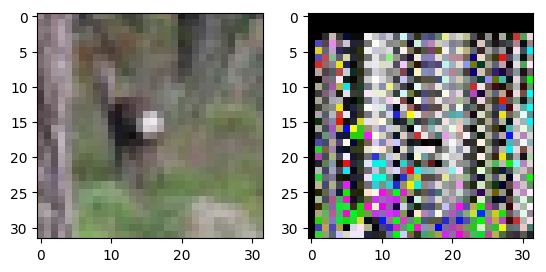

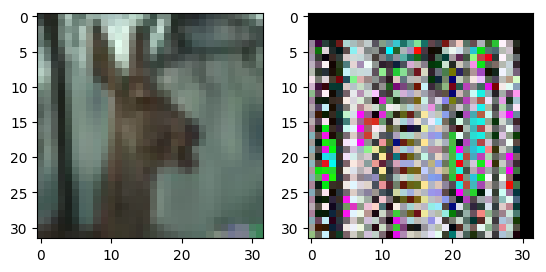

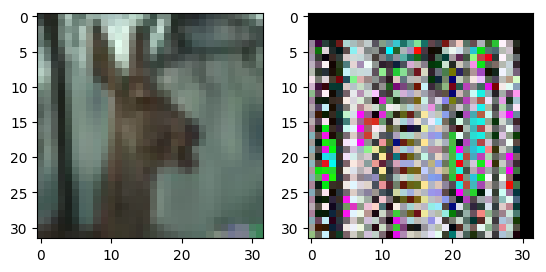

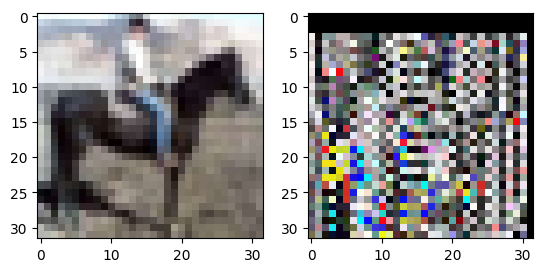

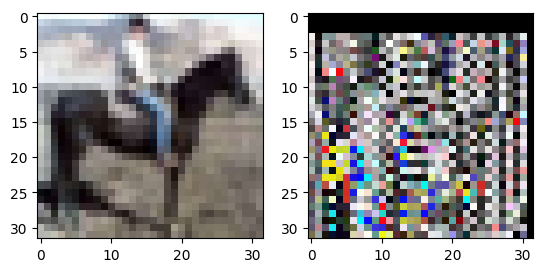

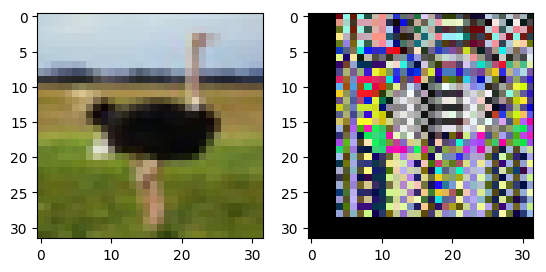

In [7]:
import matplotlib.pyplot as plt

mean,std = ([0.4914, 0.4822, 0.4465],[0.2023, 0.1994, 0.2010])

for user in test_loader:
    for batch_id, data in enumerate(user()):
        x_data = data[0]
        y_data = data[1]

        print(x_data.shape)
        print(y_data.shape)
        
        for i in range(3):
            plt.subplot(1,2,1)
            tt = UnscoreNormalization(x_data.numpy()[i].transpose(1,2,0),mean,std)
            plt.imshow(tt)
            plt.subplot(1,2,2)

            tt2 = UnscoreNormalization(y_data.numpy()[i].transpose(1,2,0),mean,std)
            plt.imshow(tt2)
            plt.show()

            plt.subplot(1,2,1)
            tt = UnscoreNormalization(x_data.numpy()[i+1].transpose(1,2,0),mean,std)
            plt.imshow(tt)
            plt.subplot(1,2,2)
            tt2 = UnscoreNormalization(y_data.numpy()[i+1].transpose(1,2,0),mean,std)
            plt.imshow(tt2)
            plt.show()
            #下面两行是消除每张图片自己单独的横纵坐标，不然每张图片会有单独的横纵坐标，影响美观
            # plt.xticks([])
            # plt.yticks([])
        break
    break

[128, 3, 32, 32]
[128, 3, 32, 32]


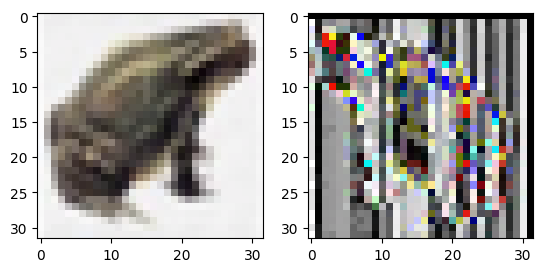

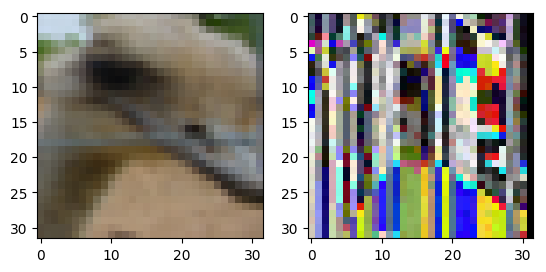

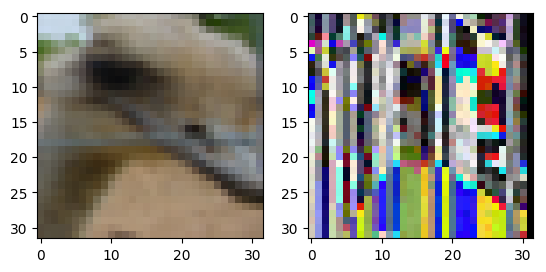

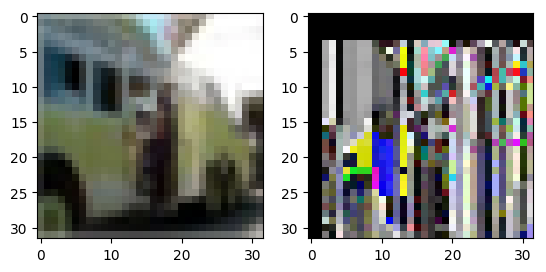

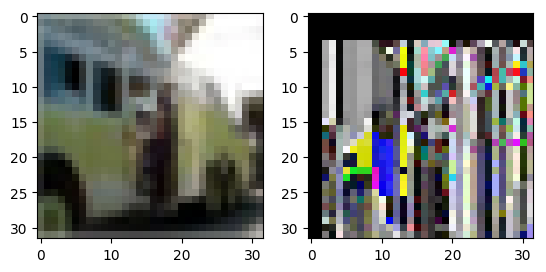

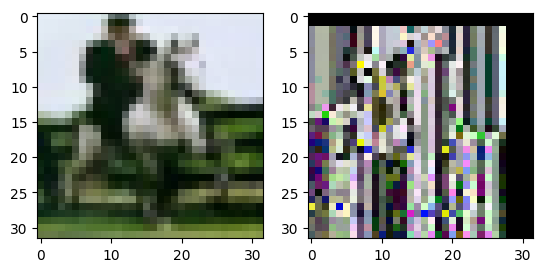

In [ ]:
import matplotlib.pyplot as plt

mean,std = ([0.4914, 0.4822, 0.4465],[0.2023, 0.1994, 0.2010])

for user in tran_loader:
    for batch_id, data in enumerate(user()):
        x_data = data[0]
        y_data = data[1]

        print(x_data.shape)
        print(y_data.shape)
        
        for i in range(3):
            plt.subplot(1,2,1)
            tt = UnscoreNormalization(x_data.numpy()[i].transpose(1,2,0),mean,std)
            plt.imshow(tt)
            plt.subplot(1,2,2)

            tt2 = UnscoreNormalization(y_data.numpy()[i].transpose(1,2,0),mean,std)
            plt.imshow(tt2)
            plt.show()

            plt.subplot(1,2,1)
            tt = UnscoreNormalization(x_data.numpy()[i+1].transpose(1,2,0),mean,std)
            plt.imshow(tt)
            plt.subplot(1,2,2)
            tt2 = UnscoreNormalization(y_data.numpy()[i+1].transpose(1,2,0),mean,std)
            plt.imshow(tt2)
            plt.show()
            #下面两行是消除每张图片自己单独的横纵坐标，不然每张图片会有单独的横纵坐标，影响美观
            # plt.xticks([])
            # plt.yticks([])
        break
    break

# 组网

In [8]:
import paddle
from paddle import nn
class Encoder(nn.Layer):#下采样：两层卷积，两层归一化，最后池化。
    def __init__(self, num_channels, num_filters):
        super(Encoder,self).__init__()#继承父类的初始化
        self.conv1 = nn.Conv2D(in_channels=num_channels,
                              out_channels=num_filters,
                              kernel_size=3,#3x3卷积核，步长为1，填充为1，不改变图片尺寸[H W]
                              stride=1,
                              padding=1)
        self.bn1   = nn.BatchNorm(num_filters,act="relu")#归一化，并使用了激活函数
        
        self.conv2 = nn.Conv2D(in_channels=num_filters,
                              out_channels=num_filters,
                              kernel_size=3,
                              stride=1,
                              padding=1)
        self.bn2   = nn.BatchNorm(num_filters,act="relu")
        
        self.pool  = nn.MaxPool2D(kernel_size=2,stride=2,padding="SAME")#池化层，图片尺寸减半[H/2 W/2]
        
    def forward(self,inputs):
        x = self.conv1(inputs)
        x = self.bn1(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x_conv = x           #两个输出，灰色 ->
        x_pool = self.pool(x)#两个输出，红色 | 
        return x_conv, x_pool
    
    
class Decoder(nn.Layer):#上采样：一层反卷积，两层卷积层，两层归一化
    def __init__(self, num_channels, num_filters):
        super(Decoder,self).__init__()
        self.up = nn.Conv2DTranspose(in_channels=num_channels,
                                    out_channels=num_filters,
                                    kernel_size=2,
                                    stride=2,
                                    padding=0)#图片尺寸变大一倍[2*H 2*W]

        self.conv1 = nn.Conv2D(in_channels=num_filters*2,
                              out_channels=num_filters,
                              kernel_size=3,
                              stride=1,
                              padding=1)
        self.bn1   = nn.BatchNorm(num_filters,act="relu")
        
        self.conv2 = nn.Conv2D(in_channels=num_filters,
                              out_channels=num_filters,
                              kernel_size=3,
                              stride=1,
                              padding=1)
        self.bn2   = nn.BatchNorm(num_filters,act="relu")
        
    def forward(self,input_conv,input_pool):
        x = self.up(input_pool)
        h_diff = (input_conv.shape[2]-x.shape[2])
        w_diff = (input_conv.shape[3]-x.shape[3])
        pad = nn.Pad2D(padding=[h_diff//2, h_diff-h_diff//2, w_diff//2, w_diff-w_diff//2])
        x = pad(x)                                #以下采样保存的feature map为基准，填充上采样的feature map尺寸
        x = paddle.concat(x=[input_conv,x],axis=1)#考虑上下文信息，in_channels扩大两倍
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.conv2(x)
        x = self.bn2(x)
        return x
    
class UNet(nn.Layer):
    def __init__(self,num_classes=2):
        super(UNet,self).__init__()
        self.down1 = Encoder(num_channels=  3, num_filters=64) #下采样
        self.down2 = Encoder(num_channels= 64, num_filters=128)
        self.down3 = Encoder(num_channels=128, num_filters=256)
        self.down4 = Encoder(num_channels=256, num_filters=512)
        
        self.mid_conv1 = nn.Conv2D(512,1024,1)                 #中间层
        self.mid_bn1   = nn.BatchNorm(1024,act="relu")
        self.mid_conv2 = nn.Conv2D(1024,1024,1)
        self.mid_bn2   = nn.BatchNorm(1024,act="relu")

        self.up4 = Decoder(1024,512)                           #上采样
        self.up3 = Decoder(512,256)
        self.up2 = Decoder(256,128)
        self.up1 = Decoder(128,64)
        
        self.last_conv = nn.Conv2D(64,num_classes,1)           #1x1卷积，softmax做分类
        
    def forward(self,inputs):
        x1, x = self.down1(inputs)
        x2, x = self.down2(x)
        x3, x = self.down3(x)
        x4, x = self.down4(x)
        
        x = self.mid_conv1(x)
        x = self.mid_bn1(x)
        x = self.mid_conv2(x)
        x = self.mid_bn2(x)
        
        x = self.up4(x4, x)
        x = self.up3(x3, x)
        x = self.up2(x2, x)
        x = self.up1(x1, x)
        
        x = self.last_conv(x)
        
        return x
# paddle.summary(UNet(3), (1, 3, 32, 32))

# 训练

In [9]:
import paddle
import os
import numpy as np

import paddle.fluid as fluid
from paddle.fluid.dygraph import to_variable, save_dygraph

def co_train(nums = 10,epoch_num = 1000,use_gpu = True, load_model = True,dataSet="MNIST",meath="Mosaic",modelName="MLP"):

    place = paddle.CUDAPlace(0) if use_gpu else paddle.CPUPlace()
    with fluid.dygraph.guard(place):
        # 实例化模型
        if modelName=="UNet":
            model = UNet(3)
        elif modelName=="ResNet50":
            model = ResNet(BottleneckBlock, 50 ,num_classes=10)
            # model = vgg19(num_classes=10)
        elif modelName=="WideResNet":
            model = WideResNet(28,10,20,0.3)

        # 配置优化器
        # scheduler = paddle.optimizer.lr.CosineAnnealingDecay(learning_rate=0.1, T_max=50, verbose=True)
        # opt = paddle.optimizer.SGD(learning_rate=scheduler, parameters=model.parameters())
        opt = paddle.optimizer.Adam(learning_rate=0.001,parameters=model.parameters())
        
        # scheduler=paddle.optimizer.lr.PiecewiseDecay(boundaries=[20,40,60,100,150],values=[0.05,0.01,0.002,0.001,0.0002],verbose=True)
        
        # scheduler=paddle.optimizer.lr.PiecewiseDecay(boundaries=[60,120,160,200,240,260,280],values=[0.05,0.01,0.002,0.0004,0.0002,0.0001,0.00005],verbose=True)
        # opt = paddle.optimizer.Momentum(parameters=model.parameters(), learning_rate=scheduler, momentum=0.9,weight_decay=0.0005)

        
        # 多级目录
        savePath = os.path.join(dataSet+"_"+modelName,meath)
        if load_model and os.path.exists(savePath):
            
            model_para, model_opt = fluid.load_dygraph(savePath+"/"+modelName)

            model.load_dict(model_para)
  
        if not os.path.exists(savePath):
            os.makedirs(savePath)

        # 模型训练
        model.train()
        print('Start training...')

        for num in range(nums):
            for user in test_loader:
                # 用户i迭代epoch次
                for epoch in range(epoch_num):
                    # 用户i的数据
                    for batch_idx, (x,y) in enumerate(user()):
                        loss_fn = paddle.nn.MSELoss()
                        loss = loss_fn(model(y), x)
                        loss.backward()
                        opt.step()
                        opt.clear_grad()

                print("epoch {}, loss: {}".format(epoch,loss.numpy()))
                save_dygraph(model.state_dict(),os.path.join(savePath,modelName))
                
                if loss.numpy() < 0.002:
                    break
            # scheduler.step()

        # 模型保存
        save_dygraph(model.state_dict(),os.path.join(savePath,modelName))

import warnings

warnings.filterwarnings("ignore", category=Warning)

In [10]:
co_train(nums = 50,epoch_num = 1,load_model = False,dataSet="CIFAR10",meath="Xor5_1_64",modelName="UNet")

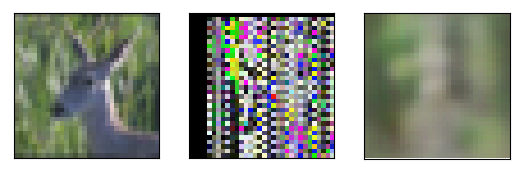

mse is 0.024757495149970055
psnr is 16.06293297356912
ssim is 0.04891969624297857


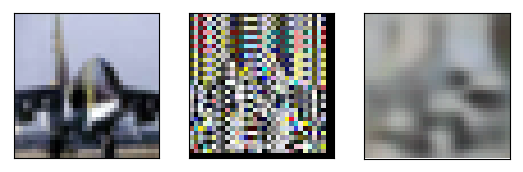

mse is 0.05513979122042656
psnr is 12.585348826261164
ssim is 0.21615464709465804


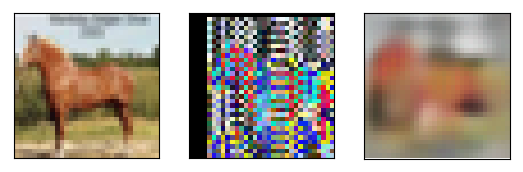

mse is 0.025804122909903526
psnr is 15.883108981465451
ssim is 0.34046679822832177


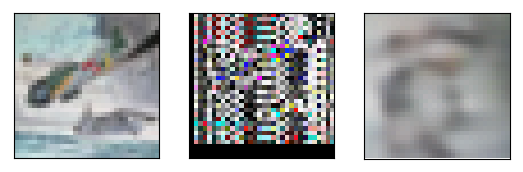

mse is 0.020905310288071632
psnr is 16.797433820290298
ssim is 0.33879319304266914


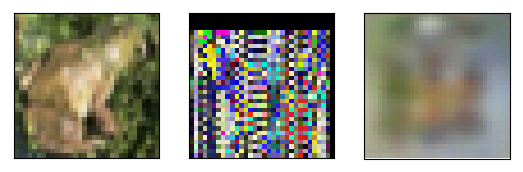

mse is 0.06414476037025452
psnr is 11.928388129479984
ssim is 0.06978761185730308


In [27]:
model=UNet(3)
model_para, _ = fluid.load_dygraph("CIFAR10_UNet/Xor5_1_32/UNet")
model.load_dict(model_para)
model.eval()

for user in test_loader:
    for (x,y) in user():
        with paddle.no_grad():
            logits=model(y)
            # print(logits.shape)

            for i in range(5):
                ori = UnscoreNormalization(x.numpy()[i].transpose(1,2,0), mean, std)
                tt = UnscoreNormalization(y.numpy()[i].transpose(1,2,0), mean, std)
                rec = UnscoreNormalization(logits.numpy()[i].transpose(1,2,0), mean, std)
                image_grid(ori,1,3,1)
                image_grid(tt,1,3,2)
                image_grid(rec,1,3,3)
                plt.show()
                
                # print(ori)
                # print(rec)
                print("psnr is {}".format(psnr(ori,rec,1.0)))
                print("ssim is {}".format(ssim(ori,rec,1.0)))
        break
    break

# 测试

In [ ]:
from paddle.vision import transforms

mean,std = ([0.4914, 0.4822, 0.4465],[0.2023, 0.1994, 0.2010])
mean = list(map(lambda x:x*255,mean))
std = list(map(lambda x:x*255,std))

# 异或图像
transform2=transforms.Compose([
        # transforms.Resize(size=64),
        transforms.RandomHorizontalFlip(),
        transforms.RandomCrop(32, 4),
        transforms.Transpose(order=(2,0,1)),
        transforms.Normalize(mean=mean,std=std),
    ])
# 原始图像
transform1=transforms.Compose([
    transforms.Transpose(order=(2,0,1)),
    transforms.Normalize(mean=mean,std=std),
])

transform = [transform1,transform2]

myobj = XORCifar10(mode='train',group = 5,xor_num = 1,xor_len = 32,data_file ="data/data46154/cifar-10.tar.gz",transform = transform)
test_loader = myobj.loader

# transform=transforms.Compose([
#         transforms.Transpose(order=(2,0,1)),
#         transforms.Normalize(mean=mean,std=std),
#     ])
# myobj = XORCifar10(mode='test',group = 5,xor_num = 1,xor_len = 1024,data_file ="data/data46154/cifar-10.tar.gz",transform = transform)
# val_loader = myobj.loader

10000
10000
10000
10000
10000
50000


In [98]:
import numpy as np
# mean = [0.4914, 0.4822, 0.4465]
# std = [0.2023, 0.1994, 0.2010]

def getXORstring(group,xor_num,xor_len):
    xorstring = []
    seeds = [15,115,215,1115,2115,415,515,615,715,815,915,315]
    # seeds = [33,133,233,1333,2333,333,433,533,633,733,833,933]
    count = 0
    for k in range(group):
        xorArray = []
        myseed = seeds[count]
        count = count+1
        for ttt in range(xor_num):
            np.random.seed(myseed)
            myseed = myseed + 2

            xorArray.append(np.random.randint(0,255,size = xor_len))

        xorstring.append(xorArray)
    
    return xorstring

def loadImg(group = 5,xor_num = 10,xor_len = 1024):
    images = []
    xor_images = []

    xorstring = getXORstring(group,xor_num,xor_len)

    for lable in range(10):
        for i in range(2):
            tep1 =  np.zeros((3,32,32))#创建一个三维的数组
            for k in range(3):
                tep1[k,:,:] = np.loadtxt("imgtxt/class"+str(lable)+"_"+str(i)+str(k)+".txt",dtype="float",delimiter=" ")
            # plt.imshow(tep.transpose(1,2,0))
            # plt.show()
            
            tep1 = tep1.transpose(1,2,0)
            tep1 = (tep1*255).astype('int32')
            tep2 = getXORImg(tep1,xorstring[0][(lable+1)*(i+1) % xor_num])
            # tep2 = tep2 / 255.

            # for k in range(3):
            #     tep2[k,:,:] = (tep2[k,:,:] - mean[k]) / std[k]

            # plt.imshow(tep,cmap=plt.cm.gray)
            # plt.show()
            images.append(tep1)
            xor_images.append(tep2)
    
    return np.array(images).reshape(-1,32,32,3),np.array(xor_images).reshape(-1,32,32,3)

def loadImg2(group = 5,xor_num = 10,xor_len = 784):
    images = []
    xor_images = []

    xorstring = getXORstring(group,xor_num,xor_len)

    for lable in range(5):
        tep1 =  np.zeros((3,32,32))#创建一个三维的数组
        for k in range(3):
            tep1[k,:,:] = np.loadtxt("img/class"+str(lable+1)+"_"+str(k)+".txt",dtype=int,delimiter=" ")
        # plt.imshow(tep.transpose(1,2,0))
        # plt.show()
        # print(tep1)
        tep1 = tep1.transpose(1,2,0).astype('int32')
        tep2 = getXORImg(tep1,xorstring[0][(lable+1)*(i+1) % xor_num])
        # tep2 = tep2 / 255.
        # tep1 = tep1 / 255.

        # for k in range(3):
        #     tep2[k,:,:] = (tep2[k,:,:] - mean[k]) / std[k]
        #     tep1[k,:,:] = (tep1[k,:,:] - mean[k]) / std[k]

        # plt.imshow(tep,cmap=plt.cm.gray)
        # plt.show()
        images.append(tep1)
        xor_images.append(tep2)
    
    return np.array(images).reshape(-1,32,32,3),np.array(xor_images).reshape(-1,32,32,3)

aaaaa


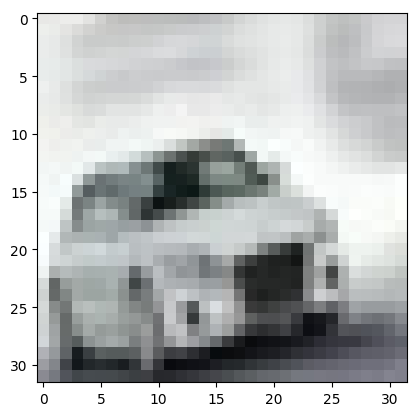

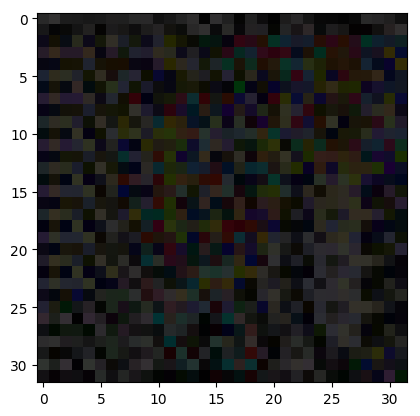

<class 'numpy.ndarray'>
(5, 32, 32, 3)
<class 'numpy.ndarray'>
(5, 32, 32, 3)


In [99]:
import paddle # 导入paddle库
import paddle.fluid as fluid
import numpy as np
from util import *

echo("aaaaa")

images, xor_images = loadImg2(5,1,128)

plt.imshow(images[1])
plt.show()
plt.imshow(UnscoreNormalization(xor_images[0],mean,std))
plt.show()
print(type(images))
print(images.shape)

print(type(xor_images))
print(xor_images.shape)

alll = []
for i in range(len(images)):
    alll.append((images[i],xor_images[i]))

In [100]:
import paddle
from paddle.io import Dataset
import numpy as np
from paddle.vision.transforms import Compose, Normalize,ToTensor,ColorJitter,RandomHorizontalFlip

class CustomCifar10(Dataset):

    def __init__(self,
                 data = None,
                 transform=None):
      
        self.data = data
        self.transform = transform

        self.dtype = paddle.get_default_dtype()

    def __getitem__(self, idx):
        image, xor_image = self.data[idx]
        
        if self.transform is not None:
            image = self.transform[0](image)
            xor_image = self.transform[1](xor_image)

        return image.astype(self.dtype), xor_image.astype(self.dtype)

    def __len__(self):
        return len(self.data)

# ToTensor默认输出为"CHW",data_format='HWC'
transform = Compose([ColorJitter(),RandomHorizontalFlip(),ToTensor()])

from paddle.vision import transforms

mean,std = ([0.4914, 0.4822, 0.4465],[0.2023, 0.1994, 0.2010])
mean = list(map(lambda x:x*255,mean))
std = list(map(lambda x:x*255,std))

# 异或图像
transform2=transforms.Compose([
        # transforms.Resize(size=64),
        transforms.RandomHorizontalFlip(),
        transforms.RandomCrop(32, 4),
        transforms.Transpose(order=(2,0,1)),
        transforms.Normalize(mean=mean,std=std),
    ])
# 原始图像
transform1=transforms.Compose([
    transforms.Transpose(order=(2,0,1)),
    transforms.Normalize(mean=mean,std=std),
])

transform = [transform1,transform2]

test_dataset = CustomCifar10(alll,transform)


In [101]:
test_loader = paddle.io.DataLoader(test_dataset, batch_size=128, shuffle=True)

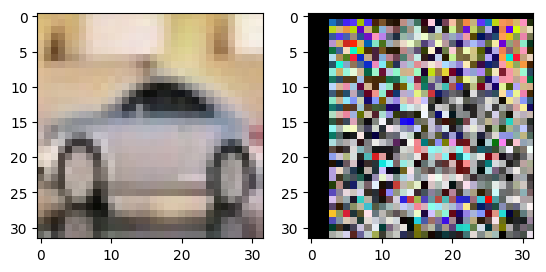

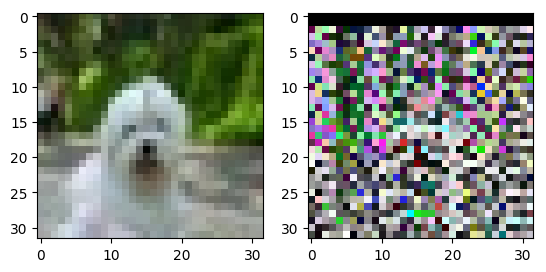

In [102]:
import matplotlib.pyplot as plt

mean,std = ([0.4914, 0.4822, 0.4465],[0.2023, 0.1994, 0.2010])

for (x_data,y_data) in test_loader:
    for i in range(3):
        plt.subplot(1,2,1)
        tt = UnscoreNormalization(x_data.numpy()[i].transpose(1,2,0),mean,std)
        plt.imshow(tt)
        plt.subplot(1,2,2)

        tt2 = UnscoreNormalization(y_data.numpy()[i].transpose(1,2,0),mean,std)
        plt.imshow(tt2)
        plt.show()

        plt.subplot(1,2,1)
        tt = UnscoreNormalization(x_data.numpy()[i+1].transpose(1,2,0),mean,std)
        plt.imshow(tt)
        plt.subplot(1,2,2)
        tt2 = UnscoreNormalization(y_data.numpy()[i+1].transpose(1,2,0),mean,std)
        plt.imshow(tt2)
        plt.show()
        #下面两行是消除每张图片自己单独的横纵坐标，不然每张图片会有单独的横纵坐标，影响美观
        # plt.xticks([])
        # plt.yticks([])
        break
    break

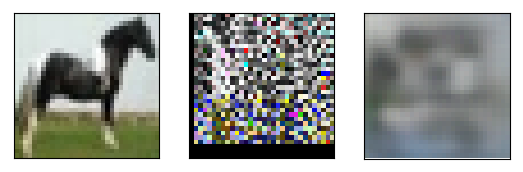

In [105]:
model=UNet(3)
# path = "CIFAR10_UNet/DP20/UNet"
path = "CIFAR10_UNet/Xor5_1_64/UNet"
model_para, _ = fluid.load_dygraph(path)

model.load_dict(model_para)
model.eval()

for (x,y) in test_loader:
    with paddle.no_grad():
        logits=model(y)
        # print(logits.shape)

        for i in range(20):
            ori = UnscoreNormalization(x.numpy()[i].transpose(1,2,0), mean, std)
            tt = UnscoreNormalization(y.numpy()[i].transpose(1,2,0), mean, std)
            rec = UnscoreNormalization(logits.numpy()[i].transpose(1,2,0), mean, std)
            image_grid(ori,1,3,1)
            image_grid(tt,1,3,2)
            image_grid(rec,1,3,3)
            plt.show()
            
            # print(ori)
            # print(rec)
            print("psnr is {}".format(psnr(ori,rec,1.0)))
            print("ssim is {}".format(ssim(ori,rec,1.0)))
        break
    break

In [30]:
def test(path = 'CIFAR10_UNet/Xor5_1_32/UNet'):
    model=UNet(3)

    model_para, _ = fluid.load_dygraph(path)

    model.load_dict(model_para)

    loss_fn = paddle.nn.MSELoss()

    model.eval()
    
    x = paddle.to_tensor(images.astype("float32"))
    y = paddle.to_tensor(xor_images.astype("float32"))
    
    x = paddle.transpose(x,[0,3,1,2])
    y = paddle.transpose(y,[0,3,1,2])

    logits=model(y)
    
    for i in range(5):
        ori = x.numpy()[i].transpose(1,2,0)
        tt = y.numpy()[i].transpose(1,2,0)
        rec = logits.numpy()[i].transpose(1,2,0)
        rec = UnscoreNormalization(rec, mean, std)
        image_grid(ori,1,3,1)
        image_grid(tt,1,3,2)
        image_grid(rec,1,3,3)
        plt.show()
        
        # print(ori)
        # print(rec)
        # UnscoreNormalization(tt, mean, std)
        ori = UnscoreNormalization(ori, mean, std)
        tt = UnscoreNormalization(tt, mean, std)
        print("psnr is {}".format(psnr(ori,rec,1.0)))
        print("psnr is {}".format(psnr(ori,tt,1.0)))
        print("ssim is {}".format(ssim(ori,rec,1.0)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


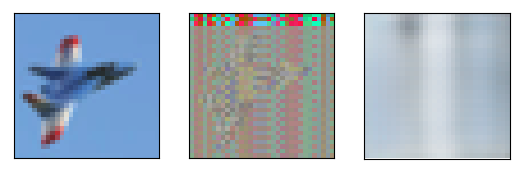

mse is 0.03483482822775841
psnr is 14.579863266514614
mse is 0.0022204245906323195
psnr is 26.535639716136473
ssim is 0.5200871767605418


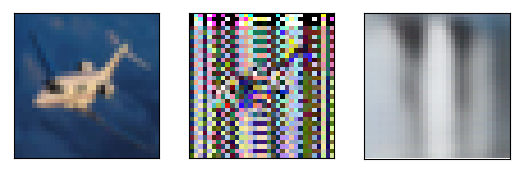

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


mse is 0.03755035623908043
psnr is 14.253859385018103
mse is 0.01362745463848114
psnr is 18.655852549278656
ssim is 0.125156020159222


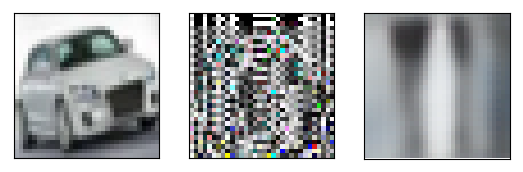

mse is 0.03324175253510475
psnr is 14.783160878884798
mse is 0.015535560436546803
psnr is 18.086730751988668
ssim is 0.18632473117121015


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


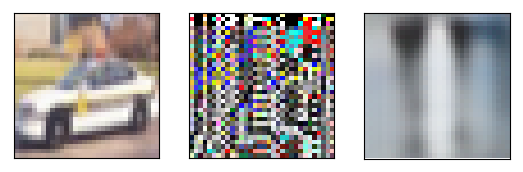

mse is 0.02798386849462986
psnr is 15.530922487527196
mse is 0.01505039632320404
psnr is 18.224520636107155
ssim is 0.21301715715148525


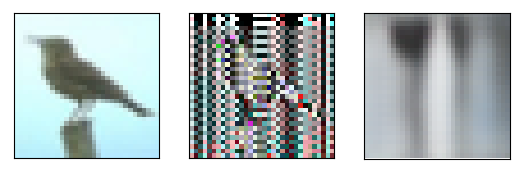

mse is 0.027605870738625526
psnr is 15.589985498817017
mse is 0.018125953152775764
psnr is 17.416991467924454
ssim is 0.19348915562027544


In [32]:
test('CIFAR10_UNet/Xor5_1_32/UNet')

In [16]:
# from paddle.vision import transforms

# mean,std = ([0.4914, 0.4822, 0.4465],[0.2023, 0.1994, 0.2010])
# mean = list(map(lambda x:x*255,mean))
# std = list(map(lambda x:x*255,std))

# # 异或图像
# transform2=transforms.Compose([
#         # transforms.Resize(size=64),
#         transforms.RandomHorizontalFlip(),
#         transforms.RandomCrop(32, 4),
#         transforms.Transpose(order=(2,0,1)),
#         transforms.Normalize(mean=mean,std=std),
#     ])
# # 原始图像
# transform1=transforms.Compose([
#     transforms.Transpose(order=(2,0,1)),
#     transforms.Normalize(mean=mean,std=std),
# ])

# transform = [transform1,transform2]

# m = 16
# b = 16
# epsilon = 5
# laplace_scal = 255*m / (b * b * epsilon)
# myobj = XORCifar10(mode='test',block= b,laplace_scal=laplace_scal,paper = "DP",data_file ="data/data46154/cifar-10.tar.gz",transform = transform)
# test_loader = myobj.loader

# # transform=transforms.Compose([
# #         transforms.Transpose(order=(2,0,1)),
# #         transforms.Normalize(mean=mean,std=std),
# #     ])
# # myobj = XORCifar10(mode='test',group = 5,xor_num = 1,xor_len = 1024,data_file ="data/data46154/cifar-10.tar.gz",transform = transform)
# # val_loader = myobj.loader

2000
2000
2000
2000
2000
10000


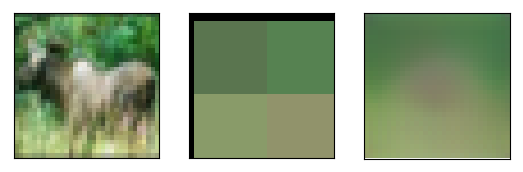

mse is 0.02298431098461151
psnr is 16.385685108419427
ssim is 0.09754339270236335


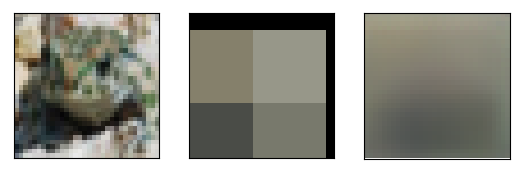

mse is 0.04409388080239296
psnr is 13.556216762497941
ssim is 0.12034715674508319


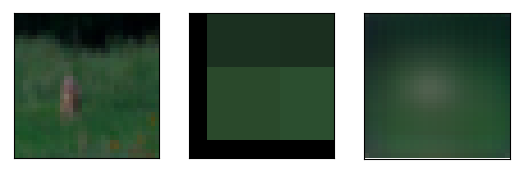

mse is 0.004254110623151064
psnr is 23.71191220968452
ssim is 0.5401224240929218


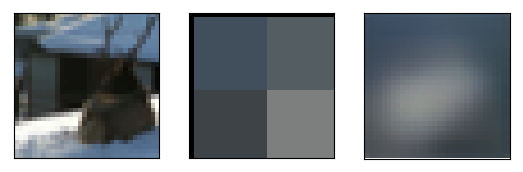

mse is 0.07199219614267349
psnr is 11.427145779556575
ssim is 0.01551509438117945


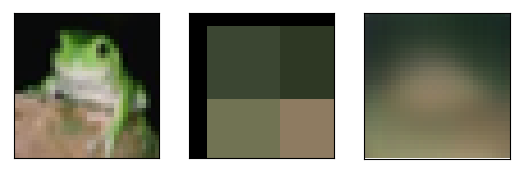

mse is 0.02870633266866207
psnr is 15.420222865524513
ssim is 0.2562895100572584


In [17]:
mean,std = ([0.4914, 0.4822, 0.4465],[0.2023, 0.1994, 0.2010])

test('CIFAR10_UNet/DP20/UNet')

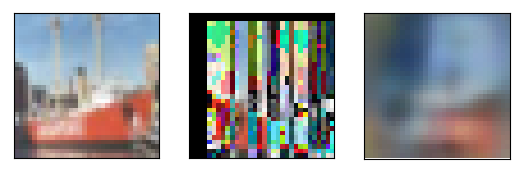

mse is 0.0536438412964344
psnr is 12.704801310047467
ssim is 0.22732011317690354


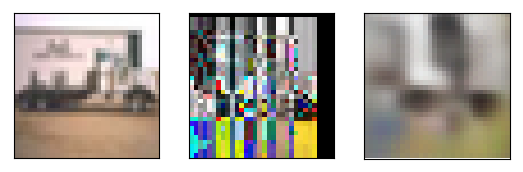

mse is 0.05275315046310425
psnr is 12.777515988191814
ssim is 0.2115849499988806


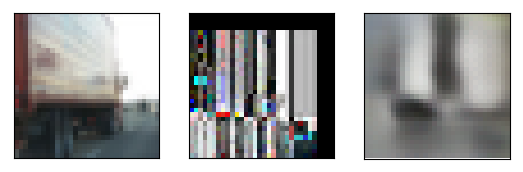

mse is 0.07705134898424149
psnr is 11.132197534246826
ssim is 0.2412624417050816


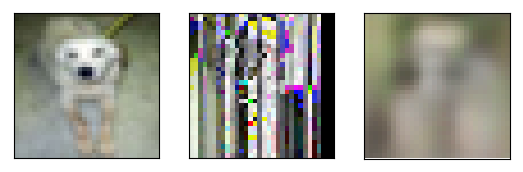

mse is 0.023417817428708076
psnr is 16.30453584192726
ssim is 0.18166957173903614
mse is 0.03723902627825737
psnr is 14.290016834240038
ssim is 0.20287934752817627


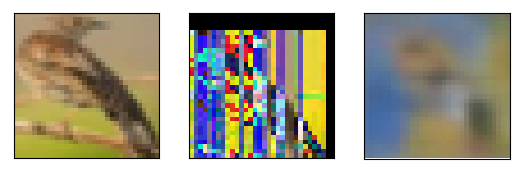

In [ ]:
mean,std = ([0.4914, 0.4822, 0.4465],[0.2023, 0.1994, 0.2010])

test()

请点击[此处](https://ai.baidu.com/docs#/AIStudio_Project_Notebook/a38e5576)查看本环境基本用法.  <br>
Please click [here ](https://ai.baidu.com/docs#/AIStudio_Project_Notebook/a38e5576) for more detailed instructions. 